In [119]:
import sys

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import statsmodels.nonparametric.api as nparam

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sys.path.append('/home/laptop/Documents/code/DL/DeepLearning/')

# TSBP model developement
Trajectory based similarity prediction models can be constructed following the floowing steps:
1. Clustering to identify regimen
1. Normalize data related to each regiment $\mu$ and $\sigma$
1. Variable weighting: $eSNR$
1. Principal component analysis (PCA): eliminate colinearity ($\sigma < 0.9$)
1. Kernel regression (non-parametric)
1. Similarity measure
1. Aggregation

In [13]:
DATA_DIR = '/home/laptop/Documents/data/aviation/NASA/Challenge_Data/'
FIG_DIR = '/home/laptop/Documents/data/aviation/NASA/Challenge_Data/figures/'
REPORT_DIR = "/home/laptop/Documents/data/aviation/NASA/Challenge_Data/reports/"

In [99]:
train_file = DATA_DIR+'train.txt'
df = pd.read_csv(train_file, sep=' ', header=None)
columns = ['device_id', 'cycles', 'setting1', 'setting2', 'setting3']
sensors = ['sensor'+str(i+1) for i in np.arange(0, 23)]
columns += sensors
df.columns = columns
df['RUL'] = np.zeros(df.shape[0])
for dev_id in df['device_id'].unique():
  df.loc[df['device_id'] == dev_id, ['RUL']] = \
               df['cycles'].max() - df['cycles']

y = df['RUL'].values

df.head(n=5)

,device_id,cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8.6216,0.03,368,2319,100.0,28.58,17.1735,NaN,NaN,356.0
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8.3907,0.03,391,2388,100.0,38.99,23.3619,NaN,NaN,355.0
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,9.3557,0.02,334,2223,100.0,14.83,8.8555,NaN,NaN,354.0
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,9.2231,0.02,364,2324,100.0,24.42,14.7832,NaN,NaN,353.0
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,9.2986,0.02,330,2212,100.0,10.99,6.4025,NaN,NaN,352.0


In [15]:
test_file = DATA_DIR+'test.txt'
df_test = pd.read_csv(test_file, sep=' ', header=None)
columns = ['device_id', 'cycles', 'setting1', 'setting2', 'setting3']
sensors = ['sensor'+str(i+1) for i in np.arange(0, 23)]
columns += sensors
df_test.columns = columns
df_test.head(n=5)

,device_id,cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029,NaN,NaN
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686,NaN,NaN
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693,NaN,NaN
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930,NaN,NaN
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124,NaN,NaN


## Clustering: regimen definition

In the literature, the data represents 6 clusters [<a href="http://ftp.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_064.pdf">Lam 2014</a>].

1. Define # regimen with k-means clustering algorithm
1. k clusters defined with Silhouette score


In [34]:
features = sensors+['setting1', 'setting2', 'setting3']
X = df[sensors+['setting1', 'setting2', 'setting3']]
X.dropna(inplace=True, axis=1)
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
silhouette_score(X, kmeans.labels_, metric='euclidean')

/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.8088210851577878

For n_clusters = 6 The average silhouette_score is : 0.8088210851577878


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 6')

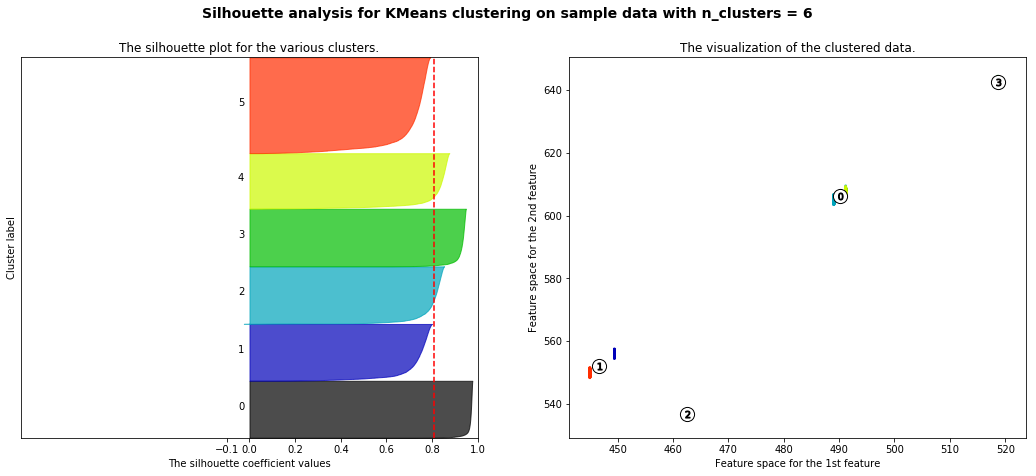

In [35]:
X = X.values
n_clusters=6

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-1.0, 1.0])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans.predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
     sample_silhouette_values[cluster_labels == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / n_clusters)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

In [28]:
X = df[sensors+['setting1', 'setting2', 'setting3']]
X.dropna(inplace=True, axis=1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
silhouette_score(X, kmeans.labels_, metric='euclidean')

/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.8872324557215985

For n_clusters = 4 The average silhouette_score is : 0.8872324557215985


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

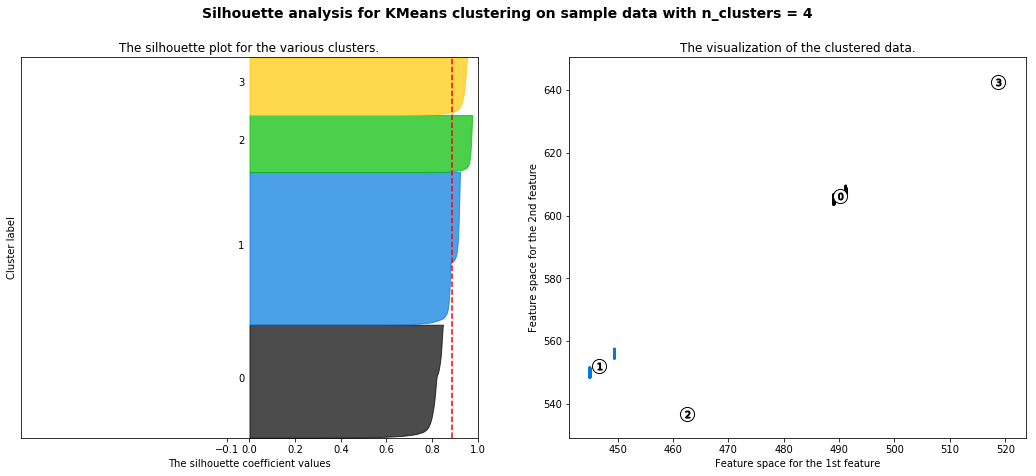

In [29]:
X = X.values
n_clusters=4

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-1.0, 1.0])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans.predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
     sample_silhouette_values[cluster_labels == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / n_clusters)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

## Data normailzation for each regimen


In [44]:
data_norm = {}
for i in range(n_clusters):
  data_norm[i] = []
  ix = np.where(cluster_labels == i)[0]
  data = X[ix,:]
    
  for j in np.arange(0, X.shape[1]):
    sample = data[:,j]
    data_norm[i].append((j, sample.mean(), sample.std()))
 
print(data_norm.keys())

dict_keys([0, 1, 2, 3, 4, 5])


In [48]:
print(data_norm[2])
data_norm.keys()

[(0, 489.07063318463105, 0.2091154867580953), (1, 604.9502489566845, 0.5763155122172561), (2, 1502.0626018132104, 5.839095320109106), (3, 1310.90137429846, 9.453545828651542), (4, 10.508719240178442, 0.1143294950967164), (5, 15.475613757375163, 0.17916143845196147), (6, 393.7401352712621, 5.942791803863526), (7, 2319.016793783278, 0.5679648825904752), (8, 8784.35812778817, 18.18075038469695), (9, 1.2581810332421932, 0.018438106552216), (10, 45.48819542380199, 0.2591529452757793), (11, 370.88947474456756, 5.590906064372626), (12, 2388.1708893365953, 0.1167236965708959), (13, 8133.856134695639, 15.758598169194997), (14, 8.671387768024175, 0.07216573408507071), (15, 0.029984170384227956, 0.0003975494698588397), (16, 369.7081594474025, 1.4734249407998359), (17, 2319.048208375306, 0.48858758588340356), (18, 100.0, 0.0), (19, 28.484757519067493, 0.4373542421373122), (20, 17.090878529284787, 0.2610157529742232), (21, 10.09938746582242, 0.9772608272091471), (22, 0.25484033673909917, 0.04396807

dict_keys([0, 1, 2, 3, 4, 5])

In [50]:
X_norm = np.zeros(X.shape)
for i in range(n_clusters):
  ix = np.where(cluster_labels == regimen)[0]
  data = X[ix,:]
  for j in np.arange(0, X.shape[1]):
    sample = data[:,j]
    data[:,j] = (sample - sample.mean())/sample.std()
  X_norm[ix,:] = data
print(X_norm.shape)

(45918, 24)


/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [53]:
np.where(X_norm == np.nan)

(array([], dtype=int64), array([], dtype=int64))

## Variable weighting
$eSNR = \frac{\sigma(sample_{smooth})}{\sigma(sample)}$

In [69]:
eSNR = []

for j in np.arange(0, X.shape[1]):
  sample = X_norm[:,j]
  d = {}
  d['sample'] = sample
  df = pd.DataFrame(data=d)
  df['sample_MAW_75'] = df['sample'].rolling(75, center=True).mean()
  df.dropna(subset=['sample_MAW_75'], axis=0, inplace=True)
  esnr = df['sample_MAW_75'].values.std()/sample.std()
  eSNR.append(esnr)

d = {}
d['j'] = np.arange(0, X.shape[1])
d['eSNR'] = eSNR
df_weight = pd.DataFrame(data=d)
df_weight.sort_values(by=['eSNR'], ascending=False).head(n=X.shape[1])

/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/laptop/Documents/code/DL/dlenv/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,j,eSNR
12,12,0.412565
7,7,0.412394
13,13,0.397503
8,8,0.385416
10,10,0.328390
14,14,0.327060
3,3,0.304744
9,9,0.275088
1,1,0.269447
16,16,0.268727


In [88]:
df_select = df_weight[df_weight['eSNR'] > 0.22]

In [89]:
X_norm_weight = X_norm[:,df_select['j'].values]
X_norm_weight.shape

(45918, 11)

## Principal Component Analysis

In [100]:
pca = PCA(n_components=5)
pca.fit(X_norm_weight)
print(pca.explained_variance_ratio_.sum())
X_norm_weight_pca = pca.transform(X_norm_weight)

0.9127373271720503


## Kernel regression degradation model

In [118]:
#model = KernelRidge(kernel="rbf", gamma=.5)
model = SVR(kernel="rbf", gamma=0.01)
model.fit(X_norm_weight_pca, y)
model.score(X_norm_weight_pca, y)

0.15471498355176772

In [ ]:
model1 = nparam.KernelReg(endog=[y], exog=[X_norm_weight_pca[:,0]], reg_type='lc', var_type='c', bw='cv_ls')
mean1, mfx1 = model1.fit()
print(mean1, mfx1)

## Similarity measure